# Plot data of the main experiments

Include all libraries

In [19]:
import lzma
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import figure_options
from matplotlib.lines import Line2D  # Import Line2D for custom legend handle
from figure_options import plt, sns, rc_parameters
from scipy.stats import bootstrap
from scipy.special import rel_entr
from environment import run_experiment, RunParameters, RunStatistics
from baifg.model.feedback_graph import FeedbackGraph
from baifg.model.reward_model import GaussianRewardModel, RewardType
from baifg.algorithms.eps_greedy import EpsilonGreedy, EpsilonGreedyParameters
from baifg.algorithms.ucb import UCB
from baifg.algorithms.exp3g import Exp3G, Exp3GParameters
from baifg.algorithms.tas_fg import TaSFG, TaSFGParameters
from baifg.algorithms.base.graph_estimator import GraphEstimator
from baifg.algorithms.base.base_algorithm import BaseAlg
from baifg.utils.graphs import make_loopless_clique, make_loopystar_graph
from baifg.utils.characteristic_time import compute_characteristic_time
from itertools import product
from typing import List, NamedTuple
from tqdm import tqdm
pd.options.mode.chained_assignment = None  # default='warn'
colors = ['#00bfc4', 'mediumorchid', '#7f7f7f','#f8766d', '#3B3B3B','#0096FF','#a3a500']


envs = ['Loopless clique', 'Loopystar', 'Ring', 'Loopystar (alt.)']

Load the data. The data is stored as a python dictionary using pickle, and compressed using LZMA. Make sure to adjust the `path` variable

In [20]:
path = f'./data/full_data.lzma'
with lzma.open(path, 'rb') as f:
    data = pickle.load(f)

df = data['df']

map_name = {
    '$\\epsilon$-greedy': r"$\epsilon$-greedy",
    '$\\epsilon$-greedy IG': r"$\epsilon$-greedy IG",
    'TaS-FG': 'TaS-FG',
    'EXP3.G': 'EXP3.G',
    'UCB':'UCB',
}

palette = {
    r"$\epsilon$-greedy": sns.color_palette("Set2")[0],
    r"$\epsilon$-greedy FG": sns.color_palette("Set2")[1],
    'EXP3.G': sns.color_palette("Set2")[2],
    'TaS-FG': sns.color_palette("Set2")[3],
    'UCB-FG-E': sns.color_palette("Set2")[4],
    'UCB-FG-V': sns.color_palette("Set2")[5],
    'TaS-FG Heur.': sns.color_palette("Set2")[6],
    'Lower bound': 'black'  # Change to 'darkred' if desired
}


Compute lower bounds and characteristic times

In [21]:
# Change names
df['env'] = df['env'].apply(lambda x: x if x != 'Loopystar (hard)' else 'Loopystar (alt.)')
df['algorithm'] = df['algorithm'].apply(lambda x: str(x))

# Compute lower bound for each environment configuration
df['lb'] = df['characteristic_time'] * (rel_entr(1-df['delta'], df['delta']) + rel_entr(df['delta'], 1-df['delta']))
taSFG_rows = df[df['algorithm'] == 'TaS-FG'].copy()
lb_df = taSFG_rows.copy()
lb_df['algorithm'] = 'Lower bound'
lb_df['stopping_time'] = lb_df['lb']
lb_df['identified_optimal_arm'] = True
df_with_lower_bound = pd.concat([df, lb_df], ignore_index=True)
df_with_lower_bound['delta'] = np.log(1/df_with_lower_bound['delta'])

# Compute normalized stopping time
df_with_lower_bound['normalized_stopping_time'] = df_with_lower_bound['stopping_time'] / df_with_lower_bound['lb']

## Make plots

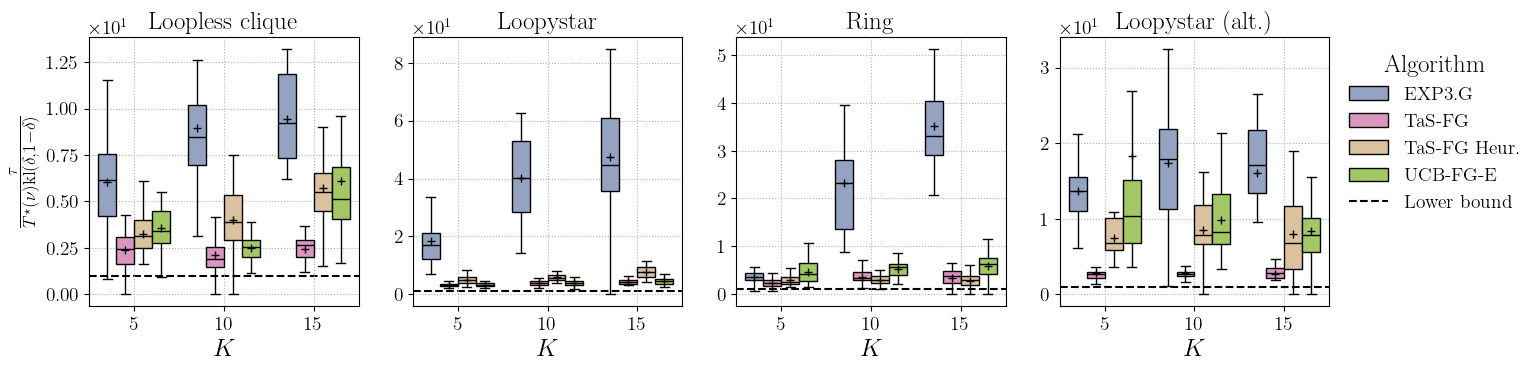

In [23]:
# envs = df_with_lower_bound['env'].unique()
num_algo = len(df_with_lower_bound['algorithm'].unique())
# Adding hatch patterns to each algorithm
hatches = {
     r"$\epsilon$-greedy": '/',
    r"$\epsilon$-greedy IG": '\\',
    'EXP3.G': '|',
    'TaS-FG': '-',
    'UCB': '+',
    'Lower bound': 'x'
}
hatches = ['-', '+', '*', r'.', '+', 'o']#, 'o', 'O', '.', '*']

fig, ax = plt.subplots(1,len(envs), figsize=(4 * len(envs),3.5))

for idx, env_name in enumerate(envs):

    # Filter the DataFrame for the selected environment
    
    df_env = df_with_lower_bound[(df_with_lower_bound['env'] == env_name) & (df_with_lower_bound['delta']==7.0)]
    df_env = df_env[df_env['algorithm'] != '$\epsilon$-greedy FG']
    df_env = df_env[df_env['algorithm'] != '$\epsilon$-greedy']
    df_env = df_env[df_env['algorithm'] != 'UCB-FG-V']
    df_env = df_env[df_env['algorithm'] != 'Lower bound']
    # Create a boxplot
    # sns.boxplot(
    #     x='K',
    #     y='stopping_time',
    #     hue='algorithm',
    #     data=df_env,
    #     palette='Set2',
    #     ax=ax[idx]
    # )
    bar = sns.boxplot(
        x='K',
        y='normalized_stopping_time',
        hue='algorithm',
        data=df_env,
        showfliers=False,
        palette=palette,
        showmeans=True,
        meanprops={'marker':'+','markerfacecolor':'black','markeredgecolor':'black','markersize':'6'},
        #errorbar=('ci', 95),           # Confidence interval
        #capsize=0.1,      # Width of the error bar caps
        #estimator='mean',  # Function to estimate central tendency
        ax=ax[idx],
        legend=True if idx == len(envs)-1 else False
    )
    ax[idx].axhline(y=1, linestyle='--', color='k', zorder=0)
    ax[idx].set_ylabel(r'')
    ax[idx].set_xlabel('$K$')
    
    ax[idx].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax[idx].set_title(env_name)
    # Adjust legend
    if idx == 0:
        ax[idx].set_ylabel(r' $\frac{\tau}{T^\star(\nu){\rm kl}(\delta,1-\delta)}$')
    if idx == len(envs)-1:
        #ax[idx].legend(title='Algorithm', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

        # Get existing handles and labels from the boxplot
        handles, labels = ax[idx].get_legend_handles_labels()
        
        # Create a custom handle for the horizontal line
        line_handle = Line2D([0], [0], color='k', linestyle='--', label='Lower bound')
        
        # Append the custom handle to the existing handles and labels
        handles.append(line_handle)
        labels.append('Lower bound')
        
        # Update the legend with the new handles and labels
        ax[idx].legend(handles=handles, title='Algorithm', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)


    ax[idx].grid(linestyle = ":")

    
plt.savefig('figures/results/sample_complexity_summary.pdf', bbox_inches='tight')

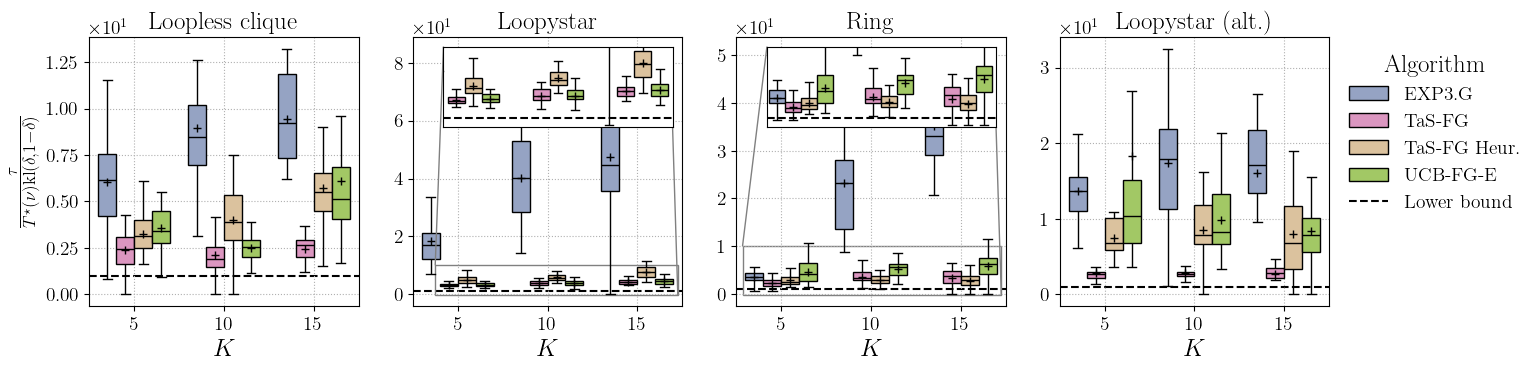

In [25]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.lines import Line2D


# envs = df_with_lower_bound['env'].unique()
num_algo = len(df_with_lower_bound['algorithm'].unique())

fig, ax = plt.subplots(1, len(envs), figsize=(4 * len(envs), 3.5))

def add_inset(ax, df_env, palette, x_limits, y_limits):
    # Create an inset axis
    axins = inset_axes(ax, width="85%", height="30%", loc='upper right')#, 
                       #bbox_transform=ax.transAxes)
    
    # Plot the same boxplot in the inset with limited y-axis
    sns.boxplot(
        x='K',
        y='normalized_stopping_time',
        hue='algorithm',
        data=df_env,
        showfliers=False,
        palette=palette,
        showmeans=True,
        meanprops={'marker':'+','markerfacecolor':'black','markeredgecolor':'black','markersize':'6'},
        ax=axins,
        legend=False
    )
    axins.axhline(y=1, linestyle='--', color='k', zorder=0)
    # Set the limits to focus on the small bars
    axins.set_xlim(x_limits)
    axins.set_ylim(y_limits)
    
    # Remove x and y ticks for clarity
    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_xlabel('')
    axins.set_ylabel('')
    
    # Optionally, add a box to indicate the zoomed area on the main plot
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
    
    return axins

for idx, env_name in enumerate(envs):
    # Filter the DataFrame for the selected environment
    df_env = df_with_lower_bound[
        (df_with_lower_bound['env'] == env_name) & 
        (df_with_lower_bound['delta'] == 7.0)
    ]
    df_env = df_env[
        ~df_env['algorithm'].isin([
            '$\epsilon$-greedy FG', 
            '$\epsilon$-greedy', 
            'UCB-FG-V', 
            'Lower bound'
        ])
    ]
    
    # Create the main boxplot
    bar = sns.boxplot(
        x='K',
        y='normalized_stopping_time',
        hue='algorithm',
        data=df_env,
        showfliers=False,
        palette=palette,
        showmeans=True,
        meanprops={'marker':'+','markerfacecolor':'black','markeredgecolor':'black','markersize':'6'},
        ax=ax[idx],
        legend=True if idx == len(envs)-1 else False
    )
    
    # Add a horizontal line for the lower bound
    ax[idx].axhline(y=1, linestyle='--', color='k', zorder=0)
    ax[idx].set_ylabel(r'')
    ax[idx].set_xlabel('$K$')
    
    # Format y-axis ticks
    ax[idx].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax[idx].set_title(env_name)
    
    # Adjust legend
    if idx == 0:
        ax[idx].set_ylabel(r' $\frac{\tau}{T^\star(\nu){\rm kl}(\delta,1-\delta)}$')
    if idx == len(envs)-1:
        # Get existing handles and labels from the boxplot
        handles, labels = ax[idx].get_legend_handles_labels()
        
        # Create a custom handle for the horizontal line
        line_handle = Line2D([0], [0], color='k', linestyle='--', label='Lower bound')
        
        # Append the custom handle to the existing handles and labels
        handles.append(line_handle)
        labels.append('Lower bound')
        
        # Update the legend with the new handles and labels
        ax[idx].legend(handles=handles, title='Algorithm', bbox_to_anchor=(1.01, 1), loc='upper left',frameon=False)
    
    # Add grid
    ax[idx].grid(linestyle=":")
    
    # Add insets to the second and third plots
    if idx in [1,2]:  # Adjust indices based on your specific requirements
        # Define the area to zoom into
        # You might need to adjust these limits based on your data
     
        # Add the inset
        add_inset(
            ax[idx],
            df_env,
            palette,
            x_limits=(-0.25 if idx == 1 else -0.43, 2.45),
            y_limits=(-0.25, 10)
        )

# plt.tight_layout()
plt.savefig('figures/results/sample_complexity_summary_insets.pdf', bbox_inches='tight')


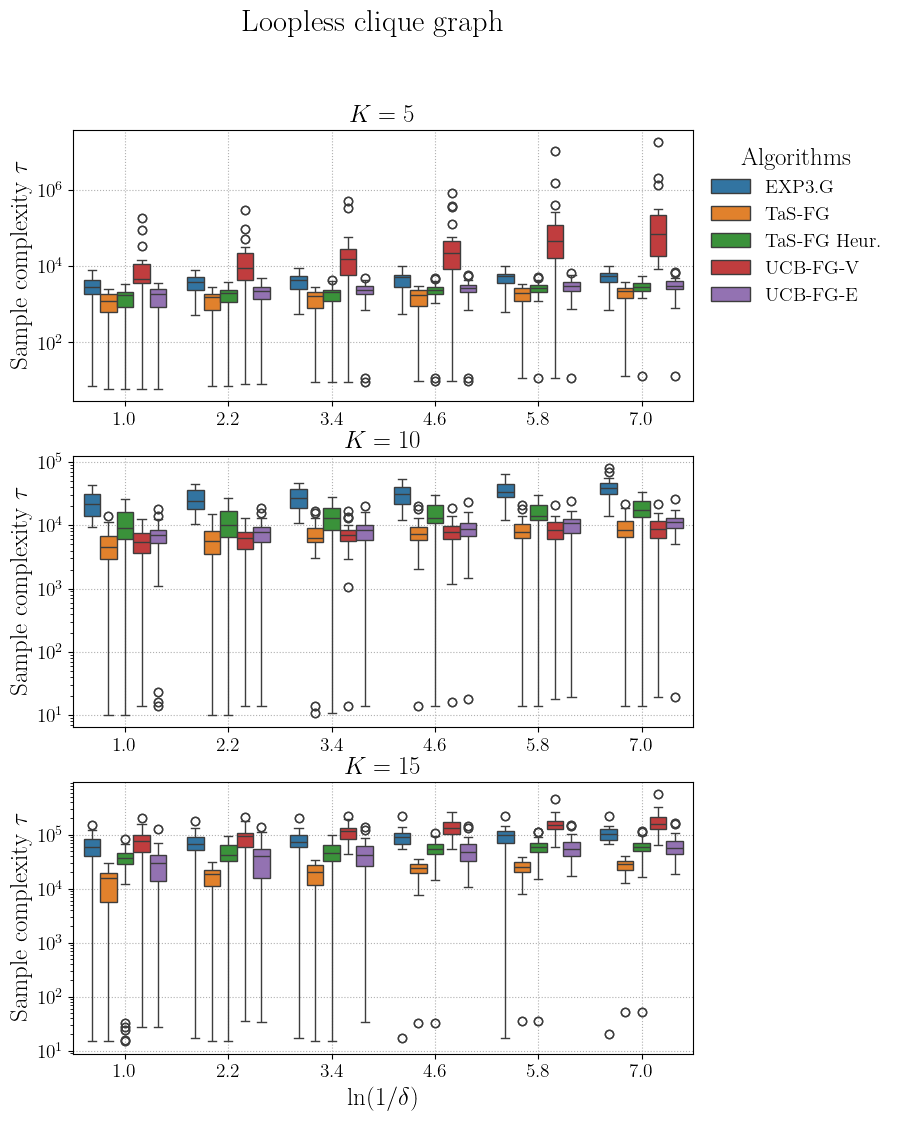

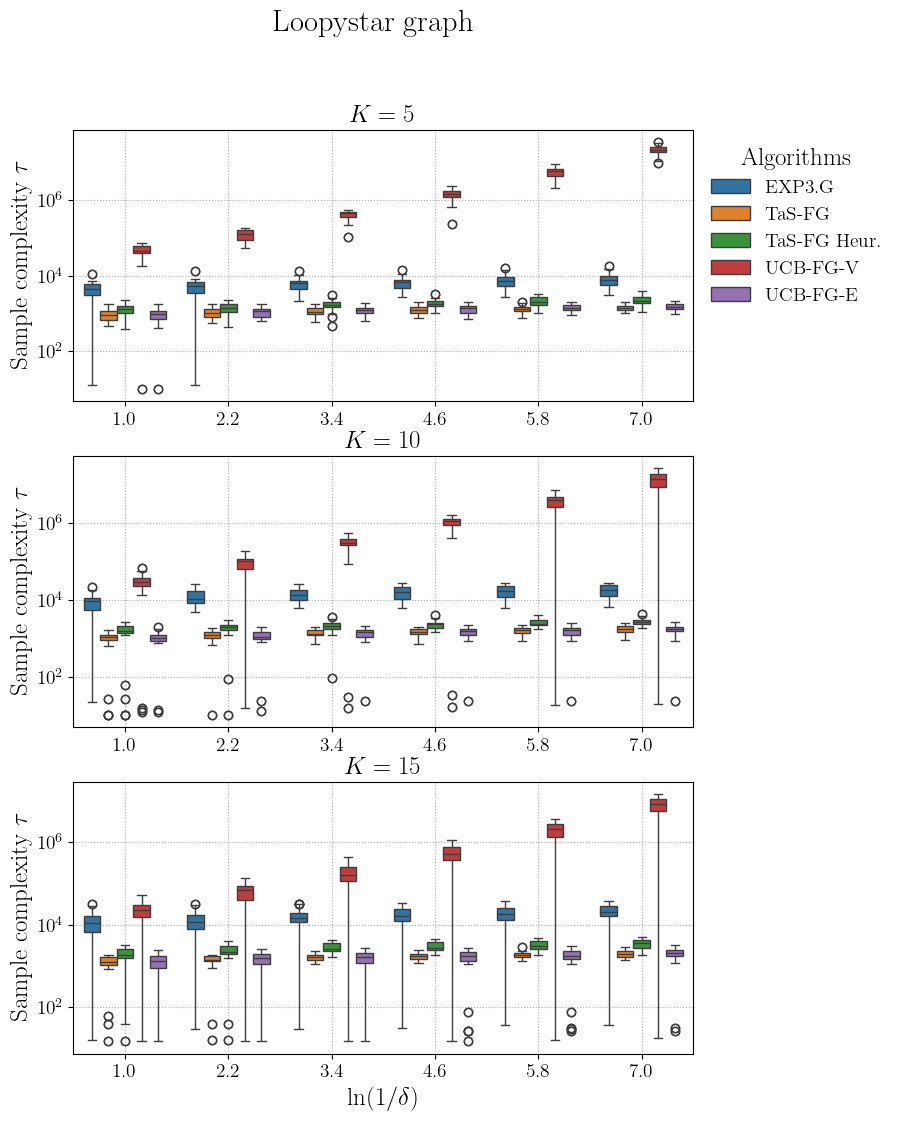

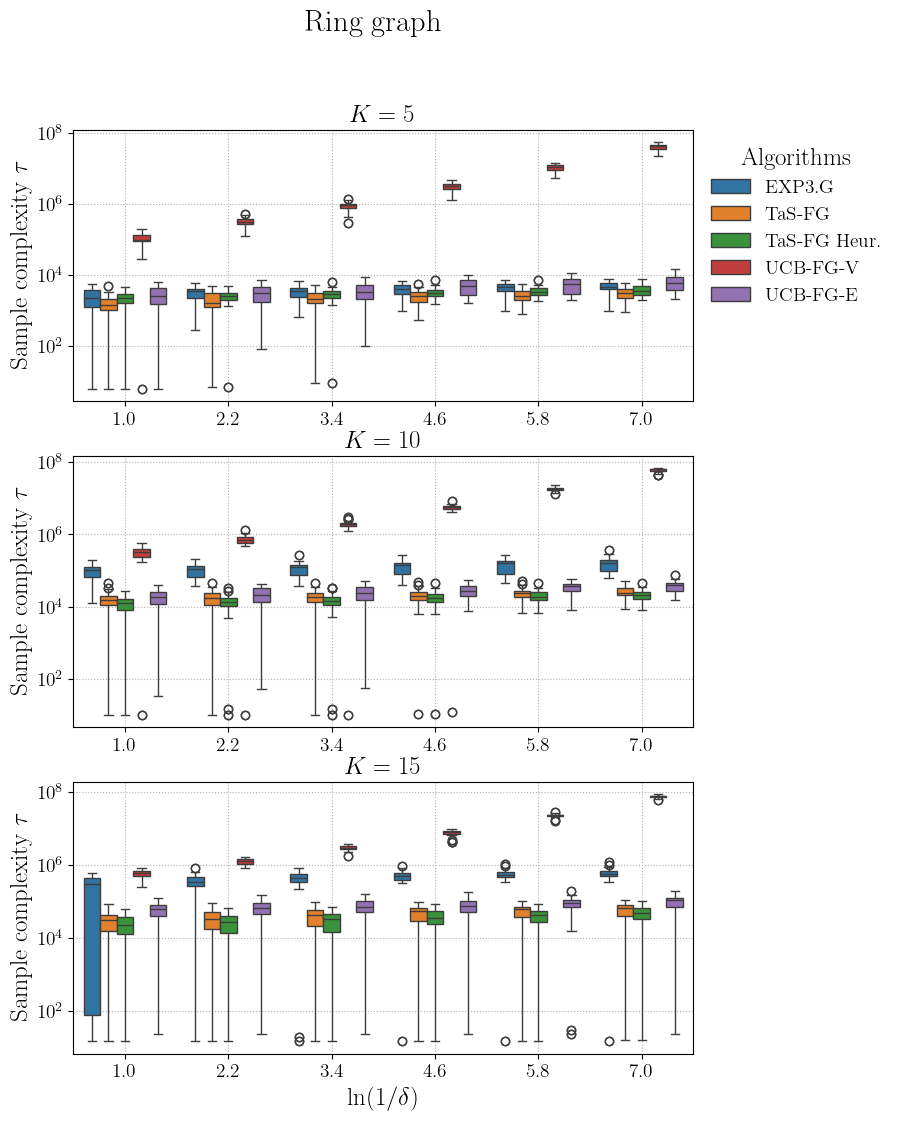

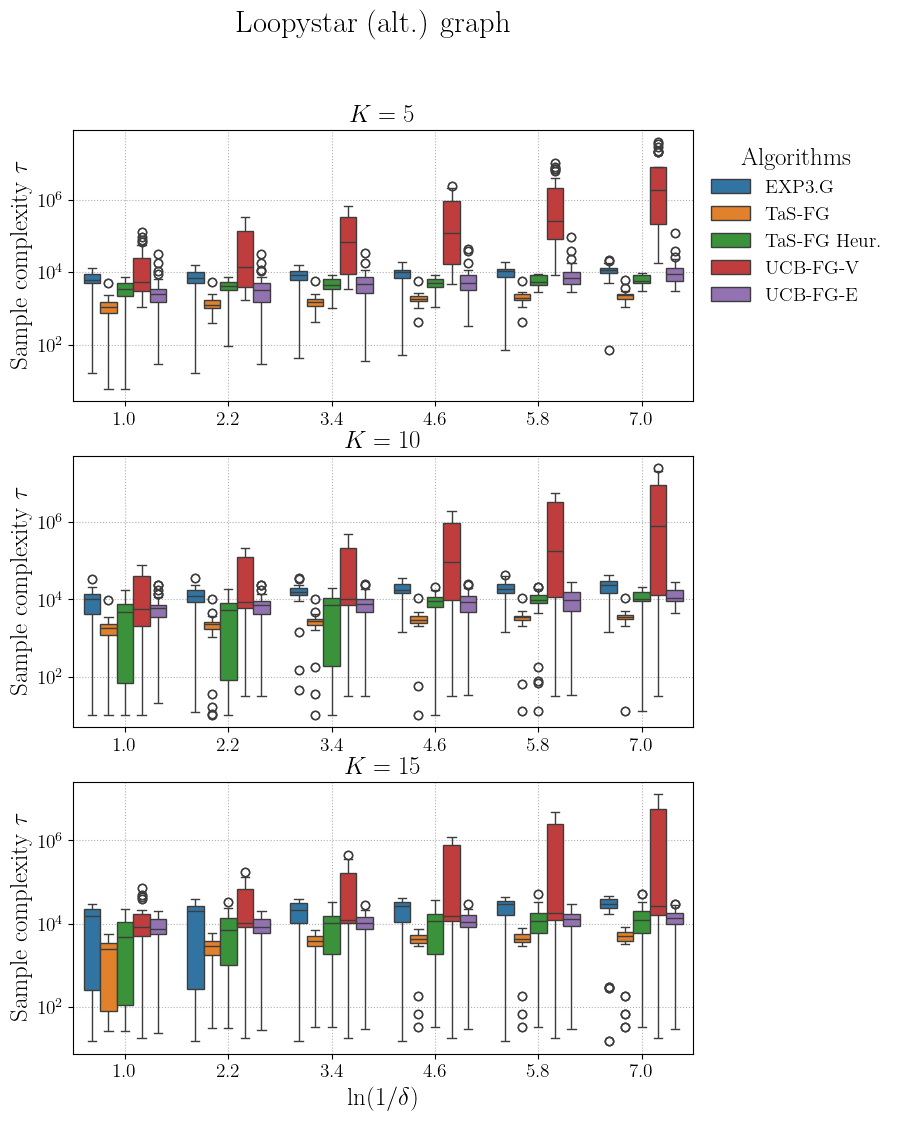

In [26]:
Kvalues = np.sort(df['K'].unique())
# envs = df['env'].unique()

for envname  in envs:
    fig, ax = plt.subplots(len(Kvalues), 1, figsize=(8,12))
    for idx, K in enumerate(Kvalues):
        # Filter the DataFrame for a given environment, e.g., "Loopless clique"
        filtered_df = df[(df['env'] == envname) & (df['K'] == K)]
        filtered_df = filtered_df[filtered_df['algorithm'] != '$\epsilon$-greedy']
        filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
        sns.boxplot(x='delta', y='stopping_time', hue='algorithm', data=filtered_df, ax=ax[idx], legend=True if idx ==0 else False)

        # Customize labels
        if idx == len(Kvalues)-1:
            ax[idx].set_xlabel(r'$\ln(1/\delta)$')
        else:
            ax[idx].set_xlabel('')
        ax[idx].set_ylabel(r'Sample complexity $\tau$')
        ax[idx].set_title(f'$K={K}$')
        ax[idx].set_yscale('log')
        ax[idx].grid(linestyle = ":")
        # ax[idx].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    # Display the plot
    ax[0].legend(title='Algorithms', bbox_to_anchor=(1., 1.), ncols=1, frameon=False)
    
    plt.suptitle(f'{envname} graph')
    plt.savefig(f'figures/results/sample_complexity_{envname}.pdf', bbox_inches='tight')

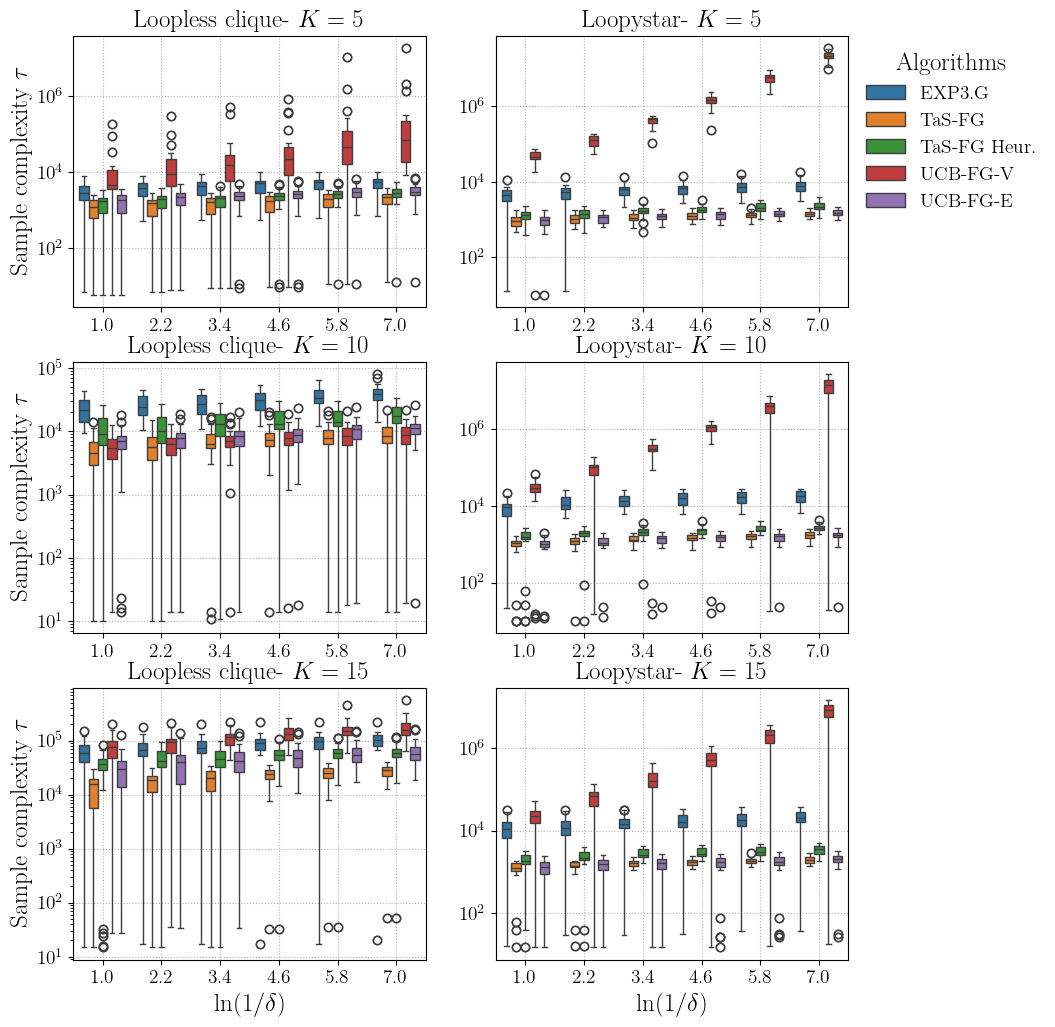

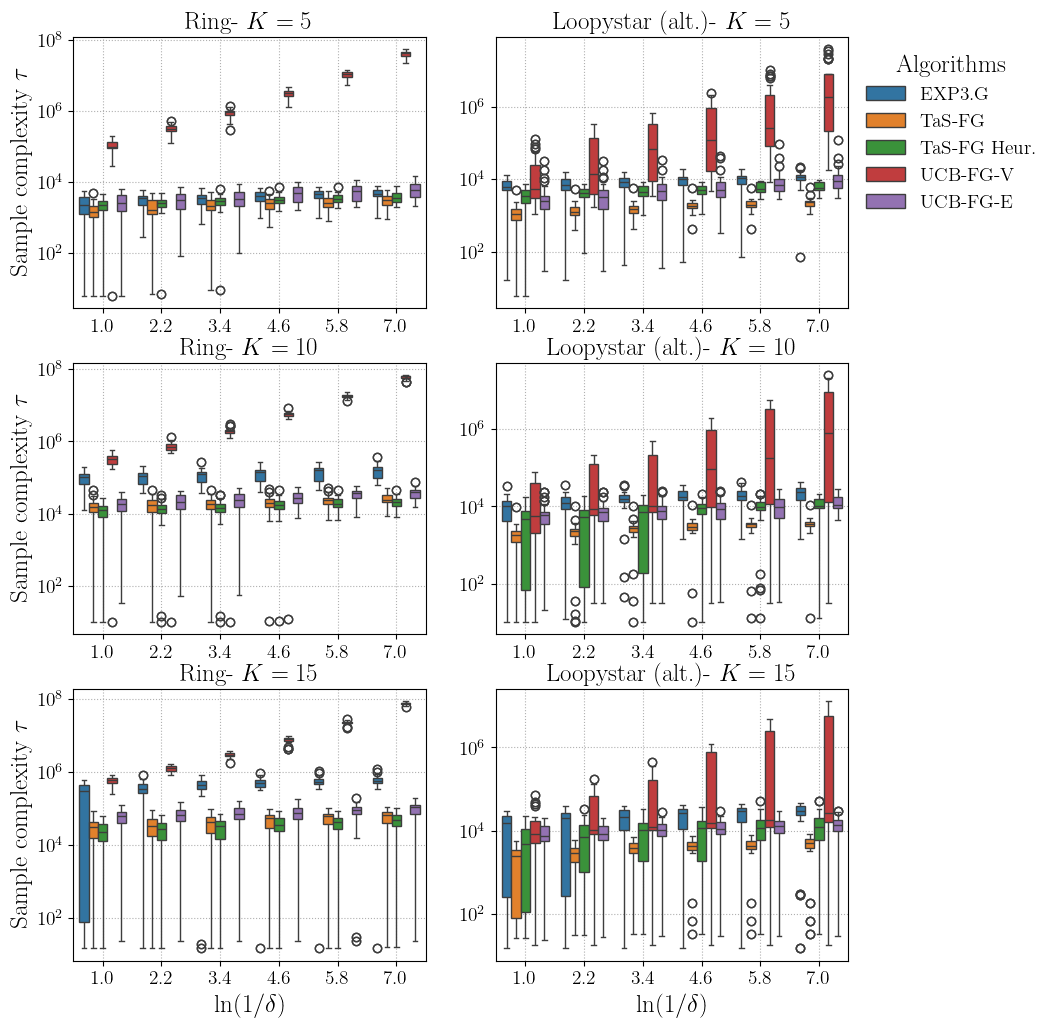

In [41]:
Kvalues = np.sort(df['K'].unique())

env_blocks = [envs[:2], envs[2:]]

for block_id, env_block in enumerate(env_blocks):
    fig, ax = plt.subplots(len(Kvalues), 2, figsize=(10,12))
    for env_id,envname  in enumerate(env_block):
        for idx, K in enumerate(Kvalues):
            # Filter the DataFrame for a given environment, e.g., "Loopless clique"
            filtered_df = df[(df['env'] == envname) & (df['K'] == K)]
            filtered_df = filtered_df[filtered_df['algorithm'] != '$\epsilon$-greedy']
            filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
            sns.boxplot(x='delta', y='stopping_time', hue='algorithm', data=filtered_df, ax=ax[idx,env_id], legend=True if idx ==0 and env_id == 1 else False)

            # Customize labels
            if idx == len(Kvalues)-1:
                ax[idx,env_id].set_xlabel(r'$\ln(1/\delta)$')
            else:
                ax[idx,env_id].set_xlabel('')
            if env_id == 0:
                ax[idx,env_id].set_ylabel(r'Sample complexity $\tau$')
            else:
                ax[idx,env_id].set_ylabel(r'')
            ax[idx,env_id].set_title(f'{envname}- $K={K}$')
            ax[idx,env_id].set_yscale('log')
            ax[idx,env_id].grid(linestyle = ":")
        # Display the plot
        if env_id == 1:
            ax[0,env_id].legend(title='Algorithms', bbox_to_anchor=(1., 1.), ncols=1, frameon=False)
        
    # plt.suptitle(f'{envname} graph')
    plt.savefig(f'figures/results/sample_complexity_{block_id+1}.pdf', bbox_inches='tight')